# Evaluate model

In [1]:
from dataset import DwgDataset
from sketch_rnn import Trainer
from IPython.display import clear_output
from plot_graphics import plot_history
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [2]:

dwg_dataset = DwgDataset(pickle_file='test_dataset_groups.pickle', batch_size=1, limit_seq_len=500)
trainer = Trainer(dwg_dataset, preload_model=True)

trainer.encoder.eval()
trainer.decoder.eval()


/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/mk/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DecoderRNN(
  (fc_hc): Linear(in_features=128, out_features=2048, bias=True)
  (lstm): LSTM(133, 1024, dropout=0.45)
  (fc_params): Linear(in_features=1024, out_features=123, bias=True)
)

In [3]:
# use imageio to create animated gif using images 


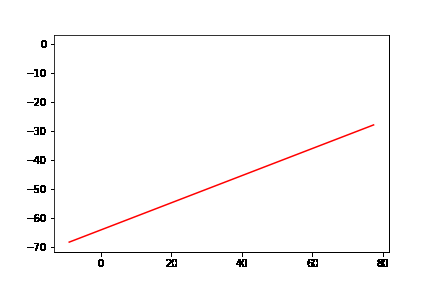

In [4]:
torch.set_printoptions(profile="full")
from plot_graphics import plot_generated_stroke_over_sequence, create_gif_from_frames

import shutil
folder = 'img_g'

if os.path.exists(folder):
    shutil.rmtree(folder)
os.mkdir(folder)

_, b = next(enumerate(dwg_dataset.train_loader))
input_seq, mask = b
input_seq = input_seq.to(trainer.device).transpose(0,1)

for i in range(1, trainer.max_seq_length):
    
    # print(i)
    seq_so_far = torch.zeros_like(input_seq)
    seq_so_far[:i+1,:,:] = input_seq[:i+1,:,: ]
    
    if seq_so_far[i,0,4]==1:
        continue

    #print(i, seq_so_far[:10])
    #print(seq_so_far.shape)
    z, _, _ = trainer.encoder(seq_so_far)

    # expand z in order it to be able to concatenate with inputs
    z_stack = torch.stack([z] * (trainer.max_seq_length))

    # inputs is the concatination of z and batch_inputs:
    inputs = torch.cat([seq_so_far, z_stack], 2)

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, _, _ = trainer.decoder(inputs, z)

    generated_stroke = trainer.sample_next_state(pi, q, mu_x, mu_y, sigma_x, sigma_y, rho_xy)
    
    #clear_output()
    graph = plot_generated_stroke_over_sequence(seq_so_far, generated_stroke, 0)
    #display(graph)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb())
    name = folder + '/gen_frame'+'{0:04d}'.format(i)+'.png'
    pil_image.save(name,"PNG")
    plt.close("all")

    
import IPython
from IPython.display import Image

img_gif = create_gif_from_frames(folder)
Image(filename=img_gif)